Author: DIVYAM
First Year Student at IIT Guwhati , CSE Department

IMPORTS AND ENVIRONMENT SETTING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

LOADING DATASET

In [2]:

train = pd.read_csv('Facebook_Marketplace_data.csv')

# Remove redundant columns (Column1 to Column4 are empty)
train = train.drop(columns=['Column1', 'Column2', 'Column3', 'Column4'])

DATA PREPROCESSING

In [3]:

# Handled missing values if any 

# Convert 'status_published' to a proper datetime format
train['status_published'] = pd.to_datetime(train['status_published'])

# Extract features
train['hour'] = train['status_published'].dt.hour
train['month'] = train['status_published'].dt.month
train['day_of_week'] = train['status_published'].dt.day_name()


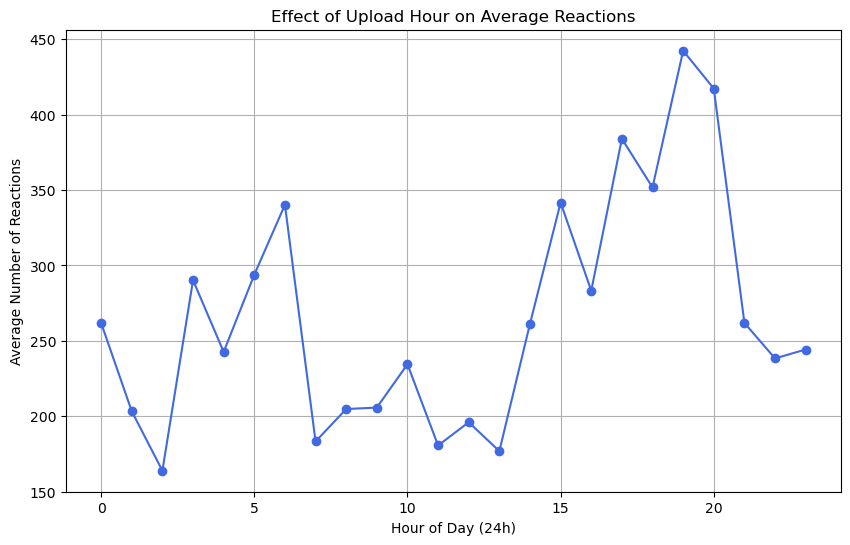

In [4]:

# Q1: Time of Upload vs. Reactions
plt.figure(figsize=(10, 6))
hourly_reactions = train.groupby('hour')['num_reactions'].mean()
hourly_reactions.plot(kind='line', marker='o', color='royalblue')
plt.title('Effect of Upload Hour on Average Reactions')
plt.xlabel('Hour of Day (24h)')
plt.ylabel('Average Number of Reactions')
plt.grid(True)
plt.show()


Correlation with num_reactions:
num_reactions    1.000000
num_likes        0.994923
num_loves        0.305003
num_wows         0.267752
num_shares       0.250723
num_hahas        0.176028
num_comments     0.150843
num_angrys       0.124326
num_sads         0.075138
Name: num_reactions, dtype: float64


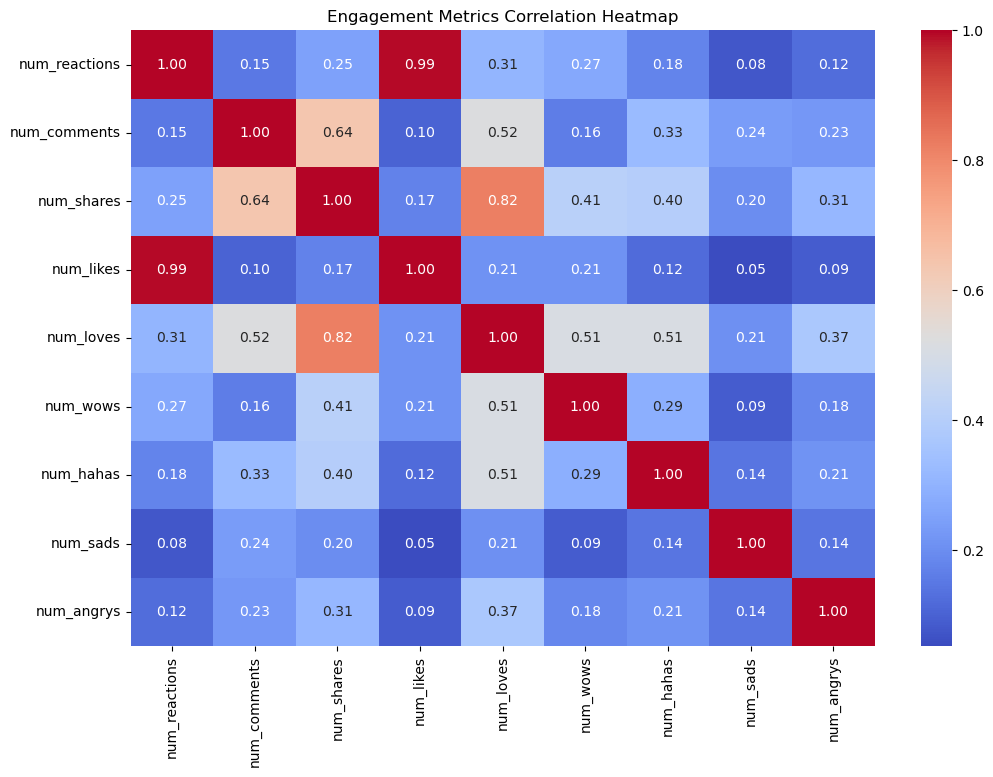

In [5]:

# Q2: Correlations Between Engagement Metrics
engagement_metrics = ['num_reactions', 'num_comments', 'num_shares', 'num_likes', 
                       'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
corr_matrix = train[engagement_metrics].corr()

print("\nCorrelation with num_reactions:")
print(corr_matrix['num_reactions'].sort_values(ascending=False))

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Engagement Metrics Correlation Heatmap')
plt.show()

In [9]:

# Q5: Count of different types of posts
post_counts = train['status_type'].value_counts()
print("\nCount of Post Types:")
print(post_counts)


# Q6: Average reactions, comments, and shares per post type
avg_metrics_type = train.groupby('status_type')[['num_reactions','num_likes', 'num_comments', 'num_shares']].mean()
print("\nAverage Metrics per Post Type:")
print(avg_metrics_type)



Count of Post Types:
status_type
photo     4288
video     2334
status     365
link        63
Name: count, dtype: int64

Average Metrics per Post Type:
             num_reactions   num_likes  num_comments  num_shares
status_type                                                     
link            370.142857  369.619048      5.698413    4.396825
photo           181.290345  178.778451     15.993470    2.553871
status          438.783562  435.528767     36.238356    2.558904
video           283.409597  243.015424    642.478149  115.679949


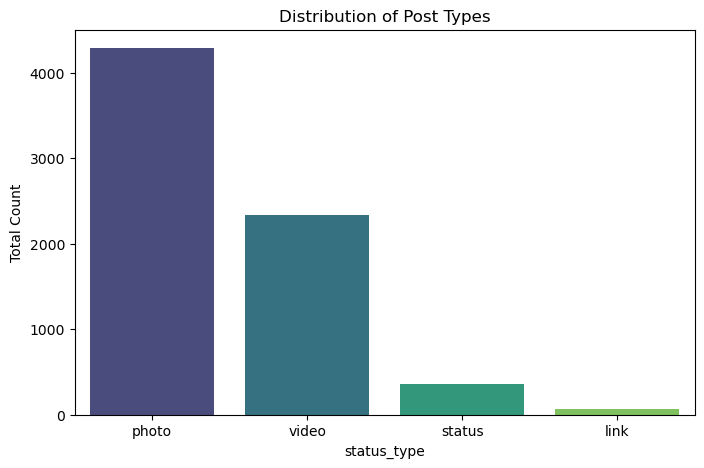

In [7]:
# Visualize Post Type Counts
plt.figure(figsize=(8, 5))

sns.barplot(x=post_counts.index, y=post_counts.values, hue=post_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Post Types')
plt.ylabel('Total Count')
plt.show()

Mathematical Optimal K: 4


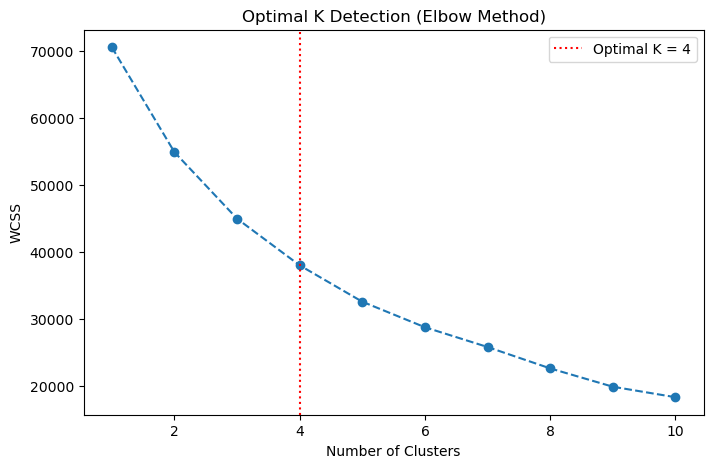

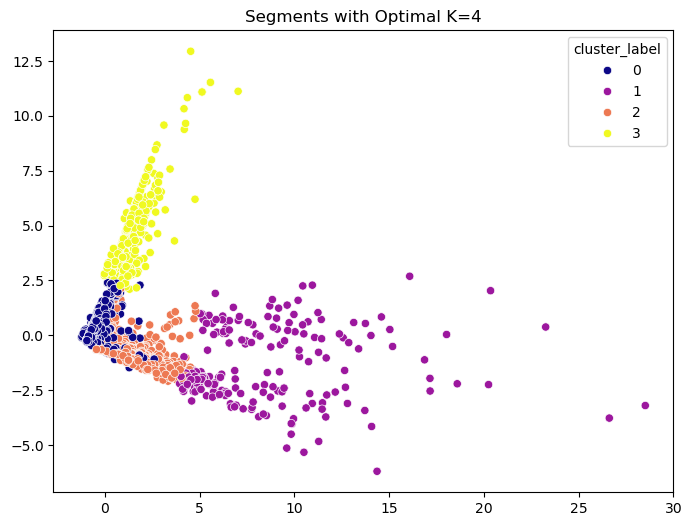

In [ ]:

# Q3 & Q4: K-Means Clustering & Elbow Method

# Preprocessing 
le = LabelEncoder()
train['status_type_encoded'] = le.fit_transform(train['status_type'])

cluster_features = ['status_type_encoded', 'num_reactions', 'num_comments', 
                    'num_shares', 'num_likes', 'num_loves', 'num_wows', 
                    'num_hahas', 'num_sads', 'num_angrys']
X = train[cluster_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate WCSS 
wcss = []
k_range = range(1, 11)
for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Optimal K Detection 
def find_optimal_k(k_values, wcss_values):
    
    x1, y1 = k_values[0], wcss_values[0]
    x2, y2 = k_values[-1], wcss_values[-1]
    
    distances = []
    for i in range(len(k_values)):
        x0, y0 = k_values[i], wcss_values[i]
       
        numerator = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator / denominator)
    
    return k_values[np.argmax(distances)]

optimal_k = find_optimal_k(list(k_range), wcss)
print(f"Mathematical Optimal K: {optimal_k}")

# Clustering
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
train['cluster_label'] = kmeans_final.fit_predict(X_scaled)

# Visualization 
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.axvline(x=optimal_k, color='red', linestyle=':', label=f'Optimal K = {optimal_k}')
plt.title('Optimal K Detection (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.show()

# Visualizing Clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=train['cluster_label'], palette='plasma')
plt.title(f'Segments with Optimal K={optimal_k}')
plt.show()